In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import Adam
import keras_tuner as kt
from keras.callbacks import EarlyStopping

In [2]:
# Load and preprocess the data
df = pd.read_csv('BATS_AAPL.csv')
df['date'] = pd.to_datetime(df['time'], utc=True)
df.set_index('date', inplace=True)

In [3]:
df_close = df[['close']].copy()
df_close = df_close.dropna()

In [4]:
#Normalize and Create Sequences
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_close)

sequence_length = 60
X, y_t1, y_t2 = [], [], []

for i in range(sequence_length, len(scaled_data) - 2):
    X.append(scaled_data[i-sequence_length:i])
    y_t1.append(scaled_data[i][0])     # Predict close at t+1
    y_t2.append(scaled_data[i+2][0])   # Predict close at t+2

X = np.array(X)
y_t1 = np.array(y_t1)
y_t2 = np.array(y_t2)

In [5]:
#Split train/val/test data set
n = len(X)
train_end = int(0.8 * n)
val_end = int(0.9 * n)

X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y1_train, y1_val, y1_test = y_t1[:train_end], y_t1[train_end:val_end], y_t1[val_end:]
y2_train, y2_val, y2_test = y_t2[:train_end], y_t2[train_end:val_end], y_t2[val_end:]

In [6]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X.shape[1], X.shape[2])))
    model.add(LSTM(hp.Int('units1', 32, 128, step=16), return_sequences=True))
    model.add(LSTM(hp.Int('units2', 32, 128, step=16)))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error'
    )
    return model

In [8]:
#Train Model for t+1
tuner1 = kt.RandomSearch(
    build_model, objective='val_loss', max_trials=10,
    directory='tuner_dir_simple', project_name='lstm_t1'
)
tuner1.search(X_train, y1_train, validation_data=(X_val, y1_val),
              epochs=20, callbacks=[EarlyStopping(patience=3)])

Trial 10 Complete [00h 04m 02s]
val_loss: 2.8927504899911582e-05

Best val_loss So Far: 2.152518936782144e-05
Total elapsed time: 00h 42m 12s


In [9]:
model1 = tuner1.get_best_models(1)[0]

C:\Users\nhuth\miniconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
y1_pred = model1.predict(X_test)
y1_pred_inv = scaler.inverse_transform(np.hstack([y1_pred, np.zeros((len(y1_pred), 3))]))[:, 0]
y1_true_inv = scaler.inverse_transform(np.hstack([y1_test.reshape(-1, 1), np.zeros((len(y1_test), 3))]))[:, 0]
current_prices = scaler.inverse_transform(np.hstack([X_test[:, -1, 0].reshape(-1, 1), np.zeros((len(X_test), 3))]))[:, 0]

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step


In [11]:
#Define Trend Classifier and Evaluation
def classify_movement(p_now, p_future):
    change = (p_future - p_now) / p_now * 100
    if change > 0.8:
        return 'strong_bullish'
    elif change > 0.4:
        return 'medium_bullish'
    elif change > 0.1:
        return 'small_bullish'
    elif change < -0.8:
        return 'strong_bearish'
    elif change < -0.4:
        return 'medium_bearish'
    elif change < -0.1:
        return 'small_bearish'
    else:
        return 'neutral'

In [12]:
#Evaluate trend prediction accuracy
def evaluate_trend(p_now, y_pred, y_true, title):
    pred_labels = [classify_movement(p, y_hat) for p, y_hat in zip(p_now, y_pred)]
    true_labels = [classify_movement(p, y_real) for p, y_real in zip(p_now, y_true)]
    print(f"\\n=== {title} ===")
    print("Accuracy:", accuracy_score(true_labels, pred_labels))
    print(classification_report(true_labels, pred_labels))
    labels = ["strong_bearish", "medium_bearish", "small_bearish", "neutral",
              "small_bullish", "medium_bullish", "strong_bullish"]
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

\n=== t+1 Prediction ===
Accuracy: 0.2285579641847314
                precision    recall  f1-score   support

medium_bearish       0.08      0.18      0.11       141
medium_bullish       0.09      0.06      0.07       145
       neutral       0.41      0.25      0.31       833
 small_bearish       0.20      0.39      0.26       426
 small_bullish       0.30      0.15      0.20       468
strong_bearish       0.01      0.02      0.02        57
strong_bullish       0.13      0.12      0.12        52

      accuracy                           0.23      2122
     macro avg       0.17      0.17      0.16      2122
  weighted avg       0.28      0.23      0.23      2122



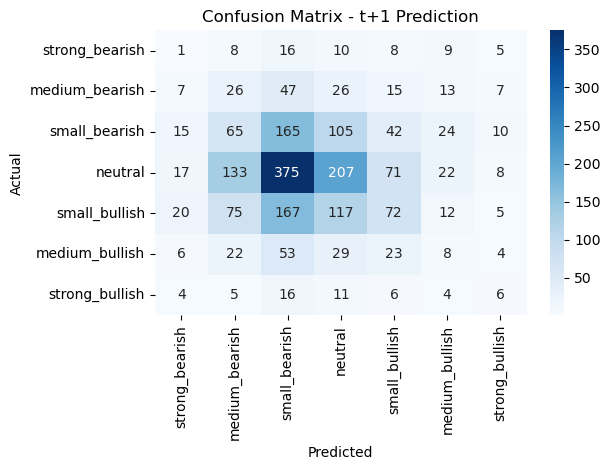

In [13]:
evaluate_trend(current_prices, y1_pred_inv, y1_true_inv, "t+1 Prediction")